In [11]:
# library(scJLIM)
suppressPackageStartupMessages({
    library(scJLIM)
    library(SingleCellExperiment)
    library(scater)
    library(cowplot)
    library(parallel)
    library(ACAT)
    library(viridis)
    library(ggrastr)
    library(JuliaCall)
})

ℹ Loading scJLIM


In [12]:
## first need to setup juliacall package for faster model fits
# install_julia() # run if julia is not already installed
julia <- julia_setup(verbose = TRUE)
julia_install_package_if_needed("MixedModels")
julia_install_package_if_needed("RCall")
julia$library("MixedModels")
julia$library("RCall")


In [13]:
# Note above that my julia install is located in:
# /home/jmitchel/.julia/juliaup/julia-1.10.4+0.x64.linux.gnu/bin
# Modify the following variable name with the directory of your install location:
julia_dir="/home/jmitchel/.julia/juliaup/julia-1.10.4+0.x64.linux.gnu/bin"

In [14]:
# load small simulated dataset with a positive colocalization in one of two cell types

data(sim_dat_all)

counts_norm <- sim_dat_all[[1]] # scRNA seq normalized and log transformed counts (genes x cells)
covar_df <- sim_dat_all[[2]] # scRNA seq metadata with donors, library size, and/or other covariates (cells x covariates)
pcs <- sim_dat_all[[3]] # scRNA seq expression PCs (cells x PCs)
donor_geno_eqtl <- sim_dat_all[[4]] # scRNA donor genotypes, maf > 0.1, but can be different (SNPs x donors)
main_tr <- sim_dat_all[[5]] # GWAS summary statistics (SNPs as rows) (CHR, BP, P as columns)
ref_matrix <- sim_dat_all[[6]] # reference LD matrix
true_ct <- sim_dat_all[[7]] # the preprogrammed cell type labels (unknown in real data)
causal_snp <- sim_dat_all[[8]] # the preprogrammed causal GWAS and eQTL SNP (unknown in real data)
eQTL_group <- sim_dat_all[[9]] # the preprogrammed cell type with the eQTL (unknown in real data)
eQTL_gene <- sim_dat_all[[10]] # the preprogrammed eGene (unknown in real data)


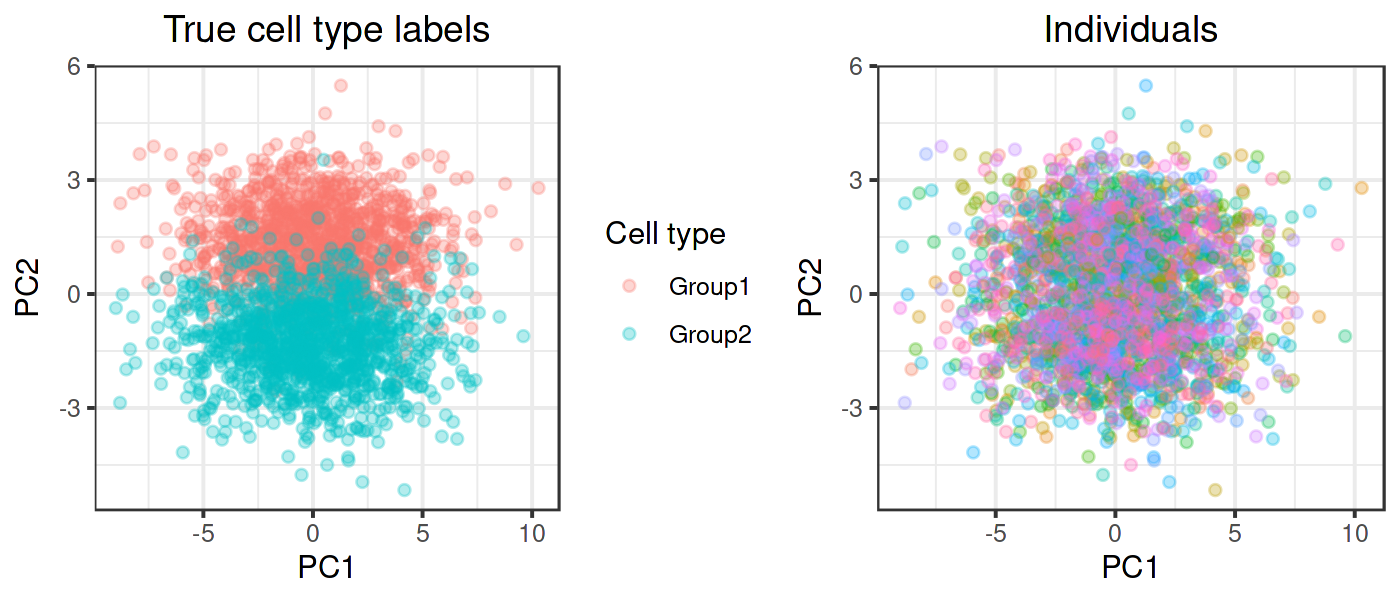

In [15]:
options(repr.plot.width = 7, repr.plot.height = 3, repr.plot.res = 200)

# looking at the scRNA-seq cell population and donor structure
tmp <- cbind.data.frame(covar_df,true_ct,pcs)
p1 <- ggplot(tmp,aes(x=PC1,y=PC2,color=Group)) + 
    geom_point(alpha=.3) +
    ggtitle('True cell type labels') +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5)) +
    guides(color=guide_legend(title="Cell type"))

p2 <- ggplot(tmp,aes(x=PC1,y=PC2,color=donors)) + 
    geom_point(alpha=.3) + 
    ggtitle('Individuals') +
    theme_bw() +
    theme(legend.position = "none",plot.title = element_text(hjust = 0.5))
plot_grid(p1,p2,nrow=1,rel_widths=c(.57,.45))


In [16]:
# In this simple example the top two PCs can separate the cell types fairly well
# Note that it is an imperfect separation, making for a more realistic 
# example where pseudobulk cluster-based eQTL mapping would introduce noise diluting
# the real signal


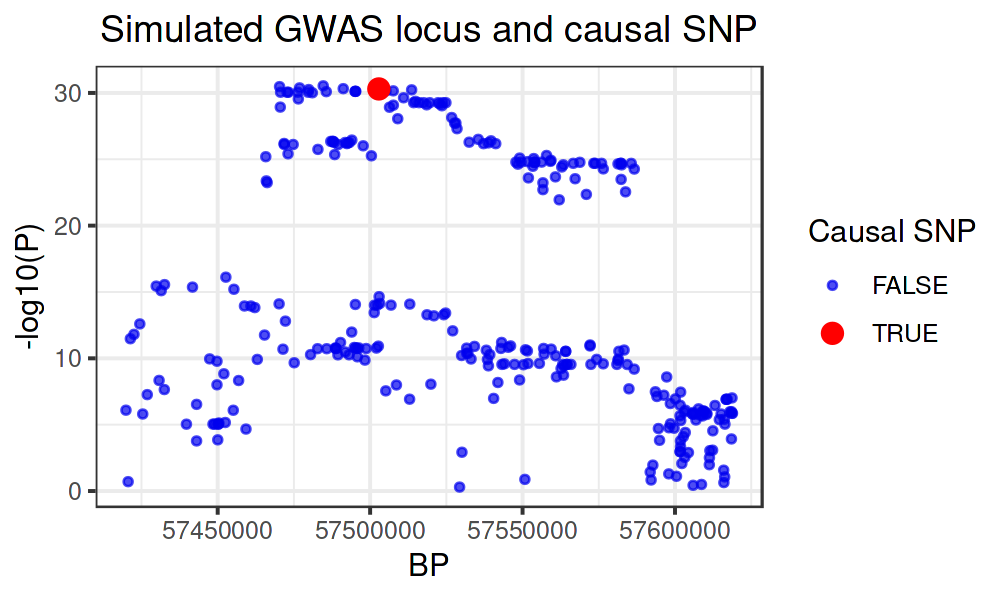

In [17]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200)

# looking at the simulated GWAS locus
main_tr$causal_snp <- rownames(main_tr)==causal_snp

p <- ggplot(main_tr,aes(x=BP,y=-log10(P),color=causal_snp,size=causal_snp)) +
    geom_point(data=main_tr[which(!main_tr$causal_snp),],alpha=.7) +
    geom_point(data=main_tr[which(main_tr$causal_snp),],alpha=1) +
    scale_size_manual(values = c("TRUE" = 3, "FALSE"=1, 1)) +
    scale_color_manual(values = c("blue2", "red1")) +
    ggtitle('Simulated GWAS locus and causal SNP') +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5)) + 
    guides(color=guide_legend(title="Causal SNP"),size=guide_legend(title="Causal SNP"))
p

# removing the causal SNP label, since we won't know it in real tests
main_tr$causal_snp <- NULL

In [18]:
# We can also see the rsid of the causal SNP
print(paste0('The causal GWAS SNP (red) is: ',causal_snp))

# This SNP was also preprogrammed to be a causal eQTL for gene-018 in the Group2 cell type
print(paste0('This SNP is also an eQTL for ',eQTL_gene,' in the ',eQTL_group,' cell type'))


[1] "The causal GWAS SNP (red) is: rs12916478"
[1] "This SNP is also an eQTL for gene-301 in the Group1 cell type"


In [19]:
# create formatted objects for scJLIM
jlim_vars <- prep_jlim(main_tr,refLD.mat=ref_matrix,min.MAF=0.05)
main_tr <- jlim_vars[[1]]

# create a null distribution from permuted genotypes
nperm <- 100000
null_dist <- get_null_dist(jlim_vars,
                           sectr.sample.size=ncol(donor_geno_eqtl),
                           nperm=nperm,r2res=.8,
                           n.cores=1)

In [20]:
# fit mixed models for each SNP in the locus
n_PCs <- 2 # number of PC interaction terms to use (must be 2 or greater)
snp_res_mat <- get_eQTL_res(gene_test = eQTL_gene, norm_counts=counts_norm,
                            cell_meta=covar_df, cell_pcs=pcs, n_PCs,
                            geno_mat=donor_geno_eqtl, main_tr=main_tr,n.cores=1,
                            progress=FALSE,
                            julia_dir=julia_dir)

# compute colocalization p-values per cell and a cauchy (global) p-value over all cells
jlim_res1 <- jlim_main(snp_res_mat, jlim_vars, null_dist, sectr.sample.size=ncol(donor_geno_eqtl),
                       min.SNPs.count=15, n.cores=1)
# extract results
cauchy_all <- jlim_res1[[1]] # global p-value over all cells
per_cell_pvals <- jlim_res1[[2]] # p-values for all individual cells


Julia version 1.10.4 at location /home/jmitchel/.julia/juliaup/julia-1.10.4+0.x64.linux.gnu/bin will be used.

Loading setup script for JuliaCall...

Finish loading setup script for JuliaCall.



In [21]:
print(cauchy_all) # this is the overall p-value indicating that there is colocalization somewhere among the tested cells

[1] 0.000780481


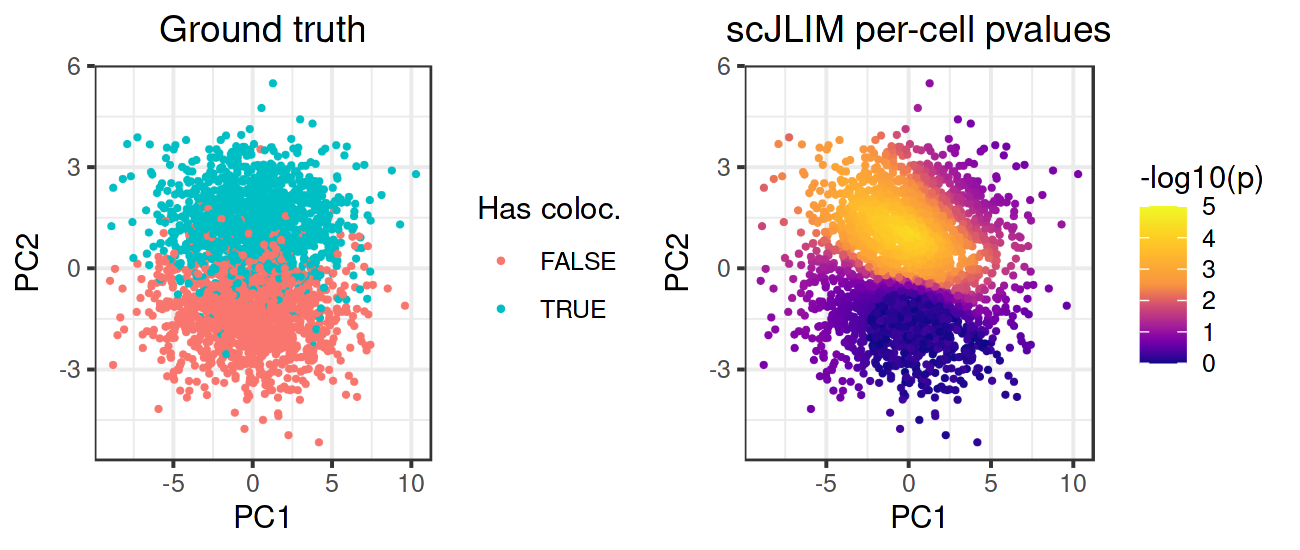

In [22]:
# plotting the per cell pvals to show that it selected the correct cell population

options(repr.plot.width = 6.5, repr.plot.height = 2.75, repr.plot.res = 200)

# looking at the scRNA-seq cell population and donor structure
tmp2 <- cbind.data.frame(tmp,per_cell_pvals)
tmp2$true_coloc_cells <- tmp2$Group==eQTL_group
tmp2 <- tmp2[sample(rownames(tmp2)),]

p1 <- ggplot(tmp2,aes(x=PC1,y=PC2,color=true_coloc_cells)) + 
    geom_point_rast(size = .5) +
    ggtitle('Ground truth') +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5)) +
    guides(color=guide_legend(title="Has coloc."))

p2 <- ggplot(tmp,aes(x=PC1,y=PC2,color=-log10(per_cell_pvals))) +
  geom_point_rast(size = .5) +
  scale_colour_gradientn(
    colors = viridis(256,option = "plasma"),
    values = scales::rescale(c(0,.15,.35,.5,1)),  # normalize your breakpoints
    limits = c(0, 5)) +
  theme_bw() +
  labs(title = 'scJLIM per-cell pvalues',
       color = "-log10(p)") +
  theme(plot.title = element_text(hjust = 0.5),
        legend.spacing.y = unit(0.1, "cm"),   # reduces vertical spacing between legend items
        legend.key.height = unit(0.4, "cm"),    # decreases the height of the legend key
        legend.key.width = unit(0.6, "cm"))

plot_grid(p1,p2,nrow=1,rel_widths=c(.5,.5))


In [23]:
# We can also select a discrete population of cells with colocalization. Done by 
# iteratively removing the most significant cell and rerunning cauchy global test.
# The set of top cells required for overall significance can be considered the cells
# contributing to the overall significance

sig_cells <- get_acat_cells(per_cell_pvals,null_dist,pv_thresh=.1,initial_step_size=1000)

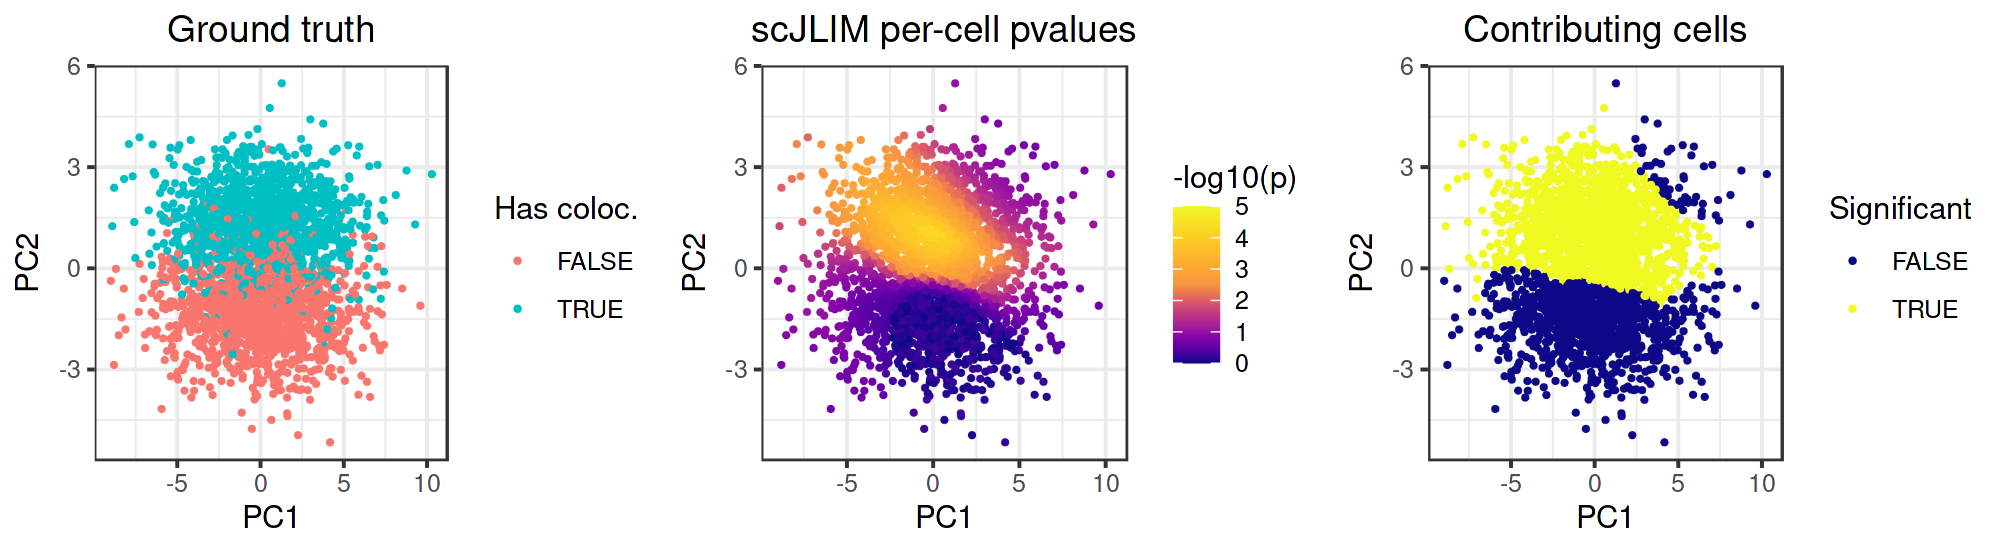

In [24]:
options(repr.plot.width = 10, repr.plot.height = 2.75, repr.plot.res = 200)

tmp2$significant <- rownames(tmp2) %in% sig_cells
p3 <- ggplot(tmp2,aes(x=PC1,y=PC2,color=significant)) +
  geom_point_rast(size = .5) +
  scale_color_viridis_d(option = "plasma") +
  theme_bw() +
  labs(title = 'Contributing cells',
       color = "Significant") +
  theme(plot.title = element_text(hjust = 0.5))

plot_grid(p1,p2,p3,nrow=1)

In [25]:
true_coloc <- tmp2[tmp2$true_coloc_cells,]
true_no_coloc <- tmp2[!tmp2$true_coloc_cells,]

sensitivity <- sum(true_coloc$significant)/nrow(true_coloc)
specificity <- 1-(sum(true_no_coloc$significant)/nrow(true_no_coloc))

print(paste0('Per-cell sensitivity: ',sensitivity))
print(paste0('Per-cell specificity: ',specificity))

[1] "Per-cell sensitivity: 0.9016"
[1] "Per-cell specificity: 0.7904"
